In [1]:
import jax
import optax
import time

import jax.numpy as jnp
import jax.random as jrd
import numpy as np
import matplotlib.pyplot as plt

from jax.random import PRNGKey
from flax import linen as nn

import sys
sys.path.insert(1, '..')
from kronojax.neural.KAN import KAN, MLP
from kronojax.neural.embedding import time_embedding

In [2]:
# Set random Key
key = jrd.PRNGKey(0)

#### (Unnormalised) Target distribution

In [3]:
def log_target(x):
    """ Mixture of two Gaussians """
    mu1 = -1.
    mu2 = 1.
    sigma2 = 0.09
    proba_1 = jnp.exp(-0.5*(x-mu1)**2 / sigma2)
    proba_2 = jnp.exp(-0.5*(x-mu2)**2 / sigma2)
    return jnp.log(0.5 * proba_1 + 0.5 * proba_2)

#### Parametrize flow and drift functions with neural networks

In [4]:
class NN_drift(nn.Module):
    """parametrize drift function"""

    time_embedding_dim: int
    time_freq_min: float
    time_freq_max: float
    dim_list: list

    @nn.compact
    def __call__(self, x, t):

        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim)
        input_forward = jnp.concatenate([x, t_embedded], axis=1)
        NN_forward = KAN(dim_list=self.dim_list, degree=2)
        # NN_forward = MLP(dim_list=self.dim_list)

        return NN_forward(input_forward)

class NN_flow(nn.Module):
    """parametrize flow function"""

    time_embedding_dim: int
    time_freq_min: float
    time_freq_max: float
    dim_list: list

    @nn.compact
    def __call__(self, x, t):

        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim)
        input_flow = jnp.concatenate([x, t_embedded], axis=1)
        NN_flow = MLP(dim_list=self.dim_list)

        return NN_flow(input_flow)
    
class NN_FlowAndDirft(nn.Module):
    """concatenate two neural networks for drift and flow"""

    time_embedding_dim: int
    time_freq_min: float
    time_freq_max: float
    dim_list_drift: list
    dim_list_flow: list

    @nn.compact
    def __call__(self, x, t):

        drift = NN_drift(time_embedding_dim=self.time_embedding_dim, 
                         time_freq_min=self.time_freq_min, time_freq_max=self.time_freq_max, dim_list=self.dim_list_drift)
        
        flow = NN_flow(time_embedding_dim=self.time_embedding_dim, 
                       time_freq_min=self.time_freq_min, time_freq_max=self.time_freq_max, dim_list=self.dim_list_flow)

        return drift(x, t), flow(x, t)

In [5]:
key, subkey = jrd.split(key)
time_embedding_dim = 16
time_freq_min = 1.
time_freq_max = 10
output_dim = 1
dim_list_drift = [32, 32, output_dim]
dim_list_flow = [32, 32, output_dim]
GFnet = NN_FlowAndDirft(time_embedding_dim, time_freq_min, time_freq_max, dim_list_drift, dim_list_flow)

# initialize the network
batch_sz = 32
key, subkey = jrd.split(key)
xs = jrd.normal(subkey, (batch_sz, 1))
ts = jrd.uniform(subkey, (batch_sz, 1))
params = GFnet.init(subkey, xs, ts)
params

{'params': {'NN_drift_0': {'KAN_0': {'ChebyKANLayer_0': {'cheby_coeffs': Array([[[-0.07041111,  0.20284824, -0.06126592],
             [ 0.00940971,  0.04172569, -0.1579823 ],
             [-0.02896337,  0.05601507, -0.11375765],
             ...,
             [ 0.1374556 , -0.22028808,  0.2900462 ],
             [-0.1632105 , -0.06120371,  0.04129769],
             [-0.02348674, -0.14249957,  0.25576115]],
     
            [[-0.39078516, -0.13679978,  0.04843318],
             [-0.03109715, -0.00769316, -0.09090478],
             [-0.02482637,  0.18937069,  0.02661465],
             ...,
             [-0.20854132, -0.02448861,  0.16933846],
             [-0.08682724, -0.07608379, -0.11177863],
             [-0.16323403,  0.13063551, -0.0215685 ]],
     
            [[ 0.40600494, -0.12630777, -0.00693014],
             [-0.1319363 ,  0.03731949, -0.09223805],
             [-0.01511926, -0.16144781,  0.24434397],
             ...,
             [ 0.05203369,  0.01608879,  0.14095777],


In [6]:
# print(params_drift['params']['KAN_0']['ChebyKANLayer_0']['cheby_coeffs'].shape)
# print(params_drift['params']['KAN_0']['LayerNorm_0']['scale'].shape)
# print(params_drift['params']['KAN_0']['LayerNorm_0']['bias'].shape)

# print(params_drift['params']['KAN_0']['ChebyKANLayer_1']['cheby_coeffs'].shape)
# print(params_drift['params']['KAN_0']['LayerNorm_1']['scale'].shape)
# print(params_drift['params']['KAN_0']['LayerNorm_1']['bias'].shape)

# print(params_drift['params']['KAN_0']['ChebyKANLayer_2']['cheby_coeffs'].shape)

# print(params_flow['params']['MLP_0']['Dense_0']['kernel'].shape)
# print(params_flow['params']['MLP_0']['Dense_0']['bias'].shape)

# print(params_flow['params']['MLP_0']['Dense_1']['kernel'].shape)
# print(params_flow['params']['MLP_0']['Dense_1']['bias'].shape)

# print(params_flow['params']['MLP_0']['Dense_2']['kernel'].shape)
# print(params_flow['params']['MLP_0']['Dense_2']['bias'].shape)

#### Define the loss function

In [7]:
def log_normal_density(x, mu, sigma2):
    """
    x: n-dim array
    mu: n-dim array
    sigma2: scalar
    """
    epsilon = 1e-10
    return - 0.5 * jnp.log(2 * jnp.pi * (sigma2 + epsilon)) - 0.5 * (x - mu)**2 / (sigma2 + epsilon)

In [8]:
def Traj(
        params: any,
        batch_sz: int,
        N_step: int,
        key: PRNGKey
        ):
    """keep track on flow function, forward probability, and backward probability"""

    T = 1.
    dt = T / N_step
    sqt = jnp.sqrt(dt)

    def _step(carry, _):
        xo, t, count, key = carry
        coeff = count / (count + 1)
        to = jnp.ones_like(xo) * t
        u, f = GFnet.apply(params, xo, to)
        key, subkey = jrd.split(key)
        dw = sqt * jrd.normal(subkey, xo.shape)
        xn = xo + u*dt + dw
        t += dt
        count += 1
        log_PF = log_normal_density(xn, xo + u*dt, dt) # Forward probability
        # log_PB = jnp.where(
        #     coeff == 0,
        #     log_normal_density(xo, coeff * xn, 1e-7), # prevent zero variance
        #     log_normal_density(xo, coeff * xn, coeff * dt) # Backward probability
        #     )
        log_PB = log_normal_density(xo, coeff * xn, coeff * dt)
        output_dict = {
            "t": t,
            "x": xn,
            "log(P_forward)": log_PF,
            "log(P_backward)": log_PB,
            "state flow": f
            }
        return (xn, t, count, subkey), output_dict
    
    key, subkey = jrd.split(key)
    t_init = 0.
    x_init = jnp.zeros((batch_sz, 1))
    count_init = 0
    carry_init = (x_init, t_init, count_init, subkey)
    _, trajectory = jax.lax.scan(_step, carry_init, xs = None, length=N_step)
    return trajectory

In [9]:
trajectory = Traj(params, batch_sz, 10, key)
print("t: ", trajectory["t"].shape)
print("x: ", trajectory["x"].shape)
print("forward: ", trajectory["log(P_forward)"].shape)
print("backward: ", trajectory["log(P_backward)"].shape)
print("flow: ", trajectory["state flow"].shape)

t:  (10,)
x:  (10, 32, 1)
forward:  (10, 32, 1)
backward:  (10, 32, 1)
flow:  (10, 32, 1)


In [10]:
def loss(
        params, 
        batch_sz: int, 
        N_step: int, 
        key: PRNGKey
        ):
    """loss function -- total trajectory balance"""
    
    trajectory = Traj(params, batch_sz, N_step, key)
    F0 = trajectory["state flow"][0]
    xN = trajectory["x"][-1]
    log_uN = log_target(xN)
    ratio1 = jnp.sum(trajectory["log(P_forward)"] - trajectory["log(P_backward)"], axis=0)
    ratio2 = jnp.log(F0) - log_uN + ratio1
    loss = jnp.mean(ratio2**2, axis=0)
    return loss.reshape(())

loss = jax.jit(loss, static_argnums=(1, 2,)) 
loss_value_grad = jax.value_and_grad(loss, argnums=0)

In [11]:
# loss(params, 32, 10, key)

#### Update parameters via loss function

In [12]:
lr = 1e-3
# optimizer = optax.adam(learning_rate=lr)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip gradients to prevent explosion
    optax.adam(learning_rate=lr)
)

opt_state = optimizer.init(params)

def update(params, opt_state, batch_sz, N_step, key):
    """update the parameters"""

    loss_value, grads = loss_value_grad(params, N_step, batch_sz, key)
    # loss_value = loss(params, batch_sz, N_step, key)
    # grads = jax.grad(loss)(params, batch_sz, N_step, key)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    # print(grads)
    return new_params, opt_state, loss_value, grads

update = jax.jit(update, static_argnums=(2, 3))

In [13]:
Niter = 5_000
Batch_SZ = 256
LR = 10**-3
# optimizer = optax.adam(learning_rate=LR)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip gradients to prevent explosion
    optax.adam(learning_rate=LR)
)

loss_values = []
params_history = []
count = 0

time_start = time.time()
while count < Niter:
    key, subkey = jrd.split(key)
    params, opt_state, loss_value, grads = update(params, opt_state, Batch_SZ, 10, subkey)
    loss_values.append(loss_value)
    params_history.append(jax.tree.map(lambda x: x.copy(), params))
    count += 1
    # print(f'Iteration {count} | Loss: {loss_value:.2f}')
    if count % 100 == 0:
        time_current = time.time()
        print(f"Iteration {count:4d} |  Loss: {loss_value:.2f}  |  Time: {time_current - time_start:.2f} s")
    # new_loss = jnp.mean(jnp.array(loss_values[-5:]))
    # old_loss = jnp.mean(jnp.array(loss_values[-8:-3]))
    # if new_loss > old_loss:
    #     break

Iteration  100 |  Loss: 106.81  |  Time: 7.40 s
Iteration  200 |  Loss: 5.28  |  Time: 11.40 s
Iteration  300 |  Loss: 1.43  |  Time: 15.65 s
Iteration  400 |  Loss: 6.64  |  Time: 19.60 s
Iteration  500 |  Loss: 11.62  |  Time: 23.27 s
Iteration  600 |  Loss: 1.46  |  Time: 26.80 s
Iteration  700 |  Loss: 2.00  |  Time: 30.36 s
Iteration  800 |  Loss: 0.80  |  Time: 34.05 s
Iteration  900 |  Loss: 0.35  |  Time: 37.71 s
Iteration 1000 |  Loss: 0.86  |  Time: 41.35 s
Iteration 1100 |  Loss: 0.73  |  Time: 45.18 s
Iteration 1200 |  Loss: 1.10  |  Time: 48.99 s
Iteration 1300 |  Loss: 0.59  |  Time: 52.77 s
Iteration 1400 |  Loss: 1.48  |  Time: 56.62 s
Iteration 1500 |  Loss: 0.55  |  Time: 60.31 s
Iteration 1600 |  Loss: 0.58  |  Time: 64.01 s
Iteration 1700 |  Loss: 0.44  |  Time: 67.74 s
Iteration 1800 |  Loss: 0.16  |  Time: 71.50 s
Iteration 1900 |  Loss: 0.31  |  Time: 75.62 s
Iteration 2000 |  Loss: 0.96  |  Time: 79.18 s
Iteration 2100 |  Loss: 1.30  |  Time: 83.41 s
Iteration 2

Text(0, 0.5, 'Loss')

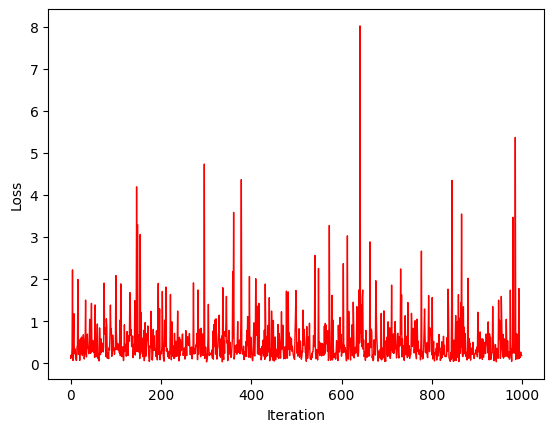

In [18]:
plt.plot(loss_values[4000:], lw=1, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [14]:
N_steps = 100
batch_sz = 10_000
key, key_ = jrd.split(key)
p = params_history[-1]
trajectory = Traj(p, batch_sz, N_steps, key_)

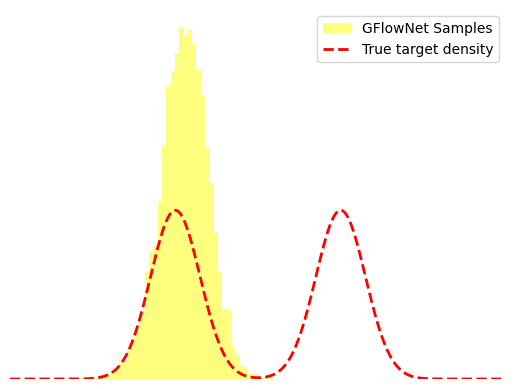

In [15]:
# histogram of the terminal values
_ = plt.hist(np.array(trajectory["x"][-1,:,0]),
             color="yellow", bins=50, density=True, 
             alpha=0.5, label="GFlowNet Samples")

# plot the true target density
x_arr = jnp.linspace(-3, 3, 1000)
dx = x_arr[1] - x_arr[0]
densities = jnp.exp(log_target(x_arr))
# normalize the density
densities = densities / jnp.sum(densities) / dx
# plot dotted lines
plt.plot(x_arr, densities,
         color='red', lw=2, ls='--', 
         label="True target density")
plt.xlim(-3, 3)

# do not show the axes
plt.axis('off')
plt.legend()
plt.show()